In [815]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import logging
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer # xverse for missing value imputation
from xverse.transformer import WOE
from sklearn.metrics import accuracy_score, classification_report,precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
# diplay logger info
logger.info("Loading train and test datasets")

2024-10-08 12:21:54,846 - INFO - Loading train and test datasets


In [816]:
def clean_data(data):
    # list all column with null
    # print(data.head()))
    #  logging('Cleaning the data ...')
    print(data.columns)

    # convert date column to datetime
    data['TransactionStartTime'] = pd.to_datetime(data['TransactionStartTime'])
    
    # print(data.top)
    print(data.head())

    return data



In [817]:
def data_summary(data):
    # logging('Summarizing the data ...')
    # data summary
    print(data.describe())
    # data info
    logging.info('Data info')
    print(data.info())
    logging.info('data types')
    print(data.dtypes)
    logging.info('top 5 rows')
    print(data.head())
    logging.info('Columns')
    print(data.columns)
    logging.info('data shapes')
    print(data.shape)
    logging.info('data null values')
    print(data.isnull().sum())

In [818]:
# visualize accountid vs amount
def account_amount_visualization(data):
    # select number of rows
    data = data.head(1000)
    plt.figure(figsize=(10,6))
    plt.scatter(data['FraudResult'], data['PricingStrategy'], alpha=0.5)
    plt.title('FraudResult vs PricingStrategy')
    plt.xlabel('FraudResult')
    plt.ylabel('PricingStrategy')
    plt.show()

In [819]:
import seaborn as sns

def correlation_graph(data):
    # correlation matrix
    print('inside correlation graph')
    data = data[['Amount','PricingStrategy','FraudResult']]
    corr = data.corr()
    plt.figure(figsize=(10,6))
    sns.heatmap(corr, annot=True)
    plt.show()

def outlier_detection(data):
    # outlier detection
    data = data[['Amount','Value','FraudResult']]
    data.boxplot()
    plt.show()

In [820]:
def eda():
    data = pd.read_csv('../../data/data.csv')
    print('loading data...')
    data = clean_data(data)

    print('plotting correlation graph...')

    data_summary(data)
    
    # account_amount_visualization(data)
    logger.info('Correlation graph')
    correlation_graph(data)
    outlier_detection(data)

    # Removing outliers beyond 99th percentile
    data = data[data['Amount'] < data['Amount'].quantile(0.99)]
    return data

### Feature Engineering

In [821]:
def aggregate_features(data):
    # group by account id
    logger.info('Aggregating data ...')
    customer_group = data.groupby('CustomerId')
    data['TotalTransactionAmount'] = customer_group['Amount'].transform('sum')
    data['AverageTransactionAmount'] = customer_group['Amount'].transform('mean')
    data['TransactionCount'] = customer_group['TransactionId'].transform('count')
    data['TransactionAmountStd'] = customer_group['Amount'].transform('std')
    return data

In [822]:
def extract_features(data):
    
    data['TransactionHour'] = data['TransactionStartTime'].dt.hour
    data['TransactionDay'] = data['TransactionStartTime'].dt.day
    data['TransactionMonth'] = data['TransactionStartTime'].dt.month
    data['TransactionYear'] = data['TransactionStartTime'].dt.year
    # print(data.columns)
    return data

In [823]:
def encode_data(data):
    logger.info('Encoding data ...')
    # encode categorical columns
    logger.info('One hot encoding data ...')
    data = pd.get_dummies(data, columns=['ProductCategory', 'ChannelId'], drop_first=True)

    logger.info('Label encoding data ...')
    le = LabelEncoder()
    data['ProviderId'] = le.fit_transform(data['ProviderId'])
    data['ProductId'] = le.fit_transform(data['ProductId'])
    data['PricingStrategy'] = le.fit_transform(data['PricingStrategy'])
    return data

In [824]:
def imputation(data):
    logger.info('Imputing missing values ...')
    imputer = SimpleImputer(strategy='mean')
    # impute missing values
    data = imputer.fit_transform(data)

    imputed_df = pd.DataFrame(data, columns=data.columns)
    return imputed_df

In [825]:
def normalize_data(data):
    logger.info('Normalizing data ...')
    # normalize data
    scaler = StandardScaler()
    data[['Amount', 'Value', 'TotalTransactionAmount', 'AverageTransactionAmount']] = scaler.fit_transform(data[['Amount', 'Value', 'TotalTransactionAmount', 'AverageTransactionAmount']])

    # Or use MinMaxScaler for normalization
    min_max_scaler = MinMaxScaler()
    data[['Amount', 'Value', 'TotalTransactionAmount', 'AverageTransactionAmount']] = min_max_scaler.fit_transform(data[['Amount', 'Value', 'TotalTransactionAmount', 'AverageTransactionAmount']])
    return data

### RFMS and WOS

In [826]:
from sklearn.preprocessing import MinMaxScaler
def get_RFMS(data):

    reference_date = data['TransactionStartTime'].max()

    rfms_df = data.groupby('CustomerId').agg(
    Recency=('TransactionStartTime', lambda x: (reference_date - x.max()).days),
    Frequency=('TransactionId', 'count'),
    Monetary=('Amount', 'sum'),
    Status=('FraudResult', 'max')
    ).reset_index()
    
    scaler = MinMaxScaler()
    rfms_df[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(rfms_df[['Recency', 'Frequency', 'Monetary']])
    rfms_df['RFMS_Score'] = rfms_df['Recency'] + rfms_df['Frequency'] - rfms_df['Monetary']
    rfms_df['Label'] = np.where(rfms_df['RFMS_Score'] > 0.5, '0', '1')
    
    return rfms_df


In [827]:

def woe_encoding(data):

    woe_transformer = WOE()

    woe_transformer.fit(data[['Recency', 'Frequency', 'Monetary']], data['Status'])

    rfms_woe = woe_transformer.transform(data[['Recency', 'Frequency', 'Monetary']])

    rfms_final = pd.concat([data[['CustomerId', 'Status', 'Label']], rfms_woe], axis=1)
    logger.info('Final RFMS data')
    print(rfms_final.head())
    


### train two models and return model with better accuracy

In [828]:
def train_model(data):
   logger.info('Training model ...')
   # split data into training and testing
   print('in train model')
   print(data.head())
   X = data[['Amount',
       'Value','PricingStrategy',
       'TotalTransactionAmount', 'AverageTransactionAmount',
       'TransactionCount', 'TransactionAmountStd', 'TransactionHour',
       'TransactionDay', 'TransactionMonth', 'TransactionYear',
       'ProductCategory_data_bundles', 'ProductCategory_financial_services',
       'ProductCategory_movies', 'ProductCategory_other',
       'ProductCategory_ticket', 'ProductCategory_transport',
       'ProductCategory_tv', 'ProductCategory_utility_bill',
       'ChannelId_ChannelId_2', 'ChannelId_ChannelId_3',
       'ChannelId_ChannelId_5', 'Recency', 'Frequency', 'Monetary', 'Status',
       'RFMS_Score', 'Label']]
   # I want to convert all the columns to numeric

   y = data['FraudResult']
   from sklearn.model_selection import train_test_split
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

   # train a model
   # smote = SMOTE(sampling_strategy='auto')
   # X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
   r_model = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced')
   r_model.fit(X_test, y_test)

   l_model = LogisticRegression( class_weight='balanced', max_iter=1000, solver='liblinear')
   l_model.fit(X_train, y_train)

   # make predictions
   y_pred_ran = r_model.predict(X_test)
   y_pred_log = l_model.predict(X_test)

   

   # evaluate the models
   print('Random Forest Classifier')
   print('Accuracy: ', accuracy_score(y_test, y_pred_ran))
   print('Precision: ', precision_score(y_test, y_pred_ran))
   print('Recall: ', recall_score(y_test, y_pred_ran))
   print('F1 Score: ', f1_score(y_test, y_pred_ran))

   print('Logistic Regression')
   print('Accuracy: ', accuracy_score(y_test, y_pred_log))
   print('Precision: ', precision_score(y_test, y_pred_log))
   print('Recall: ', recall_score(y_test, y_pred_log))
   print('F1 Score: ', f1_score(y_test, y_pred_log))
   
   print(y_test)
   if accuracy_score(y_test, y_pred_ran) > accuracy_score(y_test, y_pred_log):
      return r_model
   return l_model

In [829]:
def main():
    data = eda()
    data = aggregate_features(data)
    data = extract_features(data)
    data = data.dropna()

    data = encode_data(data)
    # data = imputation(data)
    data = normalize_data(data)

    # get_RFMS(data)
    logger.info('Data preprocessing completed')
    rfms_data = get_RFMS(data)
    data = pd.merge(data, rfms_data, on='CustomerId', how='left')

    # woe_encoding(data)
    print('final columns')
    print(data.columns)

    model = train_model(data)
    
    # export the model
    import joblib
    joblib.dump(model, 'model.pkl')

    print(data.columns)
    print(data.head())

    

2024-10-08 12:21:55,177 - INFO - Data info
2024-10-08 12:21:55,200 - INFO - data types
2024-10-08 12:21:55,201 - INFO - top 5 rows
2024-10-08 12:21:55,202 - INFO - Columns
2024-10-08 12:21:55,202 - INFO - data shapes
2024-10-08 12:21:55,203 - INFO - data null values
2024-10-08 12:21:55,225 - INFO - Correlation graph


loading data...
Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult'],
      dtype='object')
         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222   
3    TransactionId_380  BatchId_102363   AccountId_648  SubscriptionId_2185   
4  TransactionId_28195   BatchId_38780  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_4406          UGX          256  ProviderId_6  ProductId_10   
1  CustomerId_4406          UGX          256  ProviderId_4   Produ

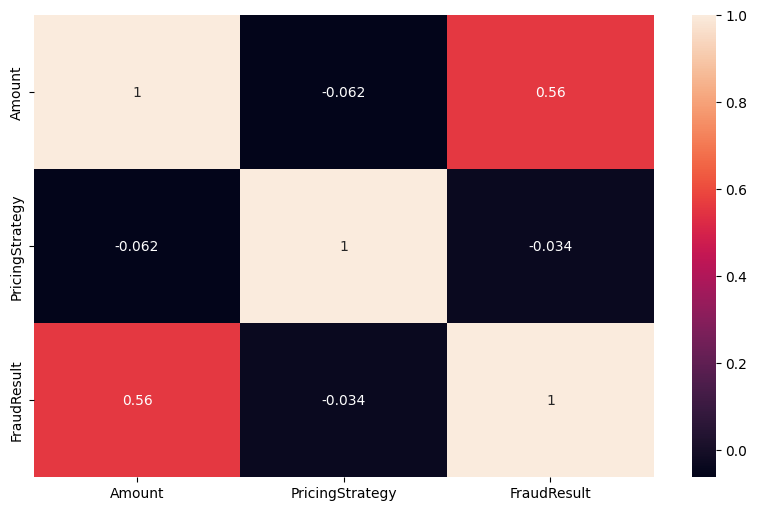

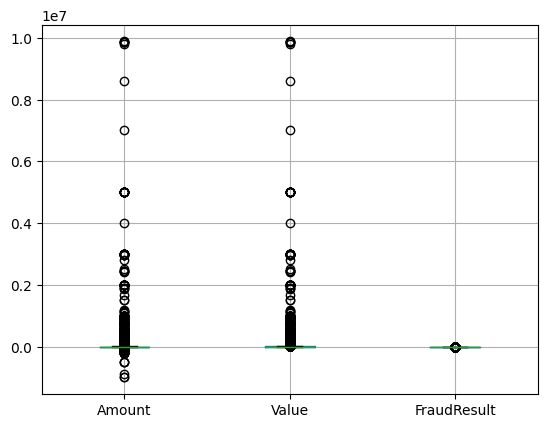

2024-10-08 12:21:55,439 - INFO - Aggregating data ...
2024-10-08 12:21:55,491 - INFO - Encoding data ...
2024-10-08 12:21:55,491 - INFO - One hot encoding data ...
2024-10-08 12:21:55,517 - INFO - Label encoding data ...
2024-10-08 12:21:55,537 - INFO - Normalizing data ...
2024-10-08 12:21:55,547 - INFO - Data preprocessing completed
2024-10-08 12:21:55,642 - INFO - Training model ...


final columns
Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId', 'Amount',
       'Value', 'TransactionStartTime', 'PricingStrategy', 'FraudResult',
       'TotalTransactionAmount', 'AverageTransactionAmount',
       'TransactionCount', 'TransactionAmountStd', 'TransactionHour',
       'TransactionDay', 'TransactionMonth', 'TransactionYear',
       'ProductCategory_data_bundles', 'ProductCategory_financial_services',
       'ProductCategory_movies', 'ProductCategory_other',
       'ProductCategory_ticket', 'ProductCategory_transport',
       'ProductCategory_tv', 'ProductCategory_utility_bill',
       'ChannelId_ChannelId_2', 'ChannelId_ChannelId_3',
       'ChannelId_ChannelId_5', 'Recency', 'Frequency', 'Monetary', 'Status',
       'RFMS_Score', 'Label'],
      dtype='object')
in train model
         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871

In [830]:
main()